In [9]:
#1D non-isothermal
#I think we should still convert it to molar flowrates somehow!!!

'''To do for thursday meeting
 - NEED TO REDO THE A/V CALCULATION
 - Fix heating term (first inlet and then furnace)
'''

from scipy.integrate import solve_bvp
import numpy as np
import matplotlib.pyplot as plt

In [10]:
def heats(T):
    #heats of reaction and heat capacity calculation from NIST
    t = T/1000

    #CH4
    A =	-0.703029
    B =	108.4773
    C =	-42.52157
    D =	5.862788
    E =	0.678565
    F =	-76.84376
    G =	158.7163
    H =	-74.87310

    dH_CH4 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CH4 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #H2O
    A =   30.09200
    B =   6.832514
    C =   6.793435
    D =  -2.534480
    E =   0.082139
    F =  -250.8810
    G =   223.3967
    H =  -241.8264

    dH_H2O = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_H2O = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #CO
    A =   25.56759
    B =   6.096130
    C =   4.054656
    D =  -2.671301
    E =   0.131021
    F =  -118.0089
    G =   227.3665
    H = -110.5271

    dH_CO = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CO = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #CO2
    A =   24.99735
    B =   55.18696
    C =  -33.69137
    D =   7.948387
    E =  -0.136638
    F =  -403.6075
    G =   228.2431
    H =  -393.5224

    dH_CO2 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CO2 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #H2
    A =  33.066178
    B = -11.363417
    C =  11.432816
    D = -2.772874
    E = -0.158558
    F = -9.980797
    G =  172.707974
    H =  0.0

    dH_H2 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_H2 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #Ar
    A =	20.78600
    B =	2.825911*10**-7
    C =	-1.464191*10**-7
    D =	1.092131*10**-8
    E =	-3.661371*10**-8
    F =	-6.197350
    G =	179.9990
    H =	0

    Cp_Ar = A + B*t + C*t**2 + D*t**3 + E/(t**2) #J/mol K

    dHsmr = (3*dH_H2 + dH_CO - dH_CH4 - dH_H2O + 206.1)*10**3 #J/mol
    dHwgs = (dH_H2 + dH_CO2 - dH_CO - dH_H2O - 41.15)*10**3 #J/mol
    # print(dHsmr)
    # print(dHwgs)
    # print([Cp_CH4, Cp_H2O, Cp_CO, Cp_CO2, Cp_H2])
    return dHsmr, dHwgs, [Cp_CH4, Cp_H2O, Cp_CO, Cp_CO2, Cp_H2, Cp_Ar]

In [11]:
#WANT TO RE-ARANGE CONSTANTS

#reactor constants
L = 0.0609 #m
R_inner = 2.39/1000 #m
R_outer = 3.5/1000 #m

A = np.pi * ((R_outer)**2-(R_inner)**2) #m^2 AXIAL AREA (GAS FLOW)
V = A*L #m^3
S = 2*np.pi*R_outer*L #m^2 RADIAL AREA (HEAT FLUX AND REACTION)

# HYDROGEN REMOVAL DISABLED h2Removal = 0 #change to 1 if there is removal of hydrogen

#gas flow constants WHEN CHANGING THE TEMPERATURE YOU NEED TO ADJUST THE INITIAL GUESS -- USING ODEINT MIGHT BE FOR BETTER CONVERSION
Tin = 622+273 #K
P = 1 #bar or atm

sccm0 = np.array([16.16, 48.48, 0, 0, 10, 5])
mols0 = sccm0/22400 * 60
boundary = np.concatenate((mols0, [Tin]))
print(boundary)

#rate equation constants
Rgas = 8.314 #J / mol·K
Easmr = 165.740 #kJ/mol
Asmr = 1.68*10**8
Eawgs = 89.23 #kJ/mol
Awgs = 9.90*10**3

Ku = 1

I = 9 #curent in Amps
F = 96485 #faradays constant

U = 0.116 #J (s K)^-1.
Ts = 298 #K

q_furn= 0

[4.32857143e-02 1.29857143e-01 0.00000000e+00 0.00000000e+00
 2.67857143e-02 1.33928571e-02 8.95000000e+02]


In [12]:
x_num = 20

x_pts = np.linspace(0,L,x_num)

#initial guess array
init_guess = np.zeros((7, x_num))
init_guess[6, :] = Tin

if Tin == 721+273:
    init_guess[0, :] = 0.05
    init_guess[1, :] = 0.3
    init_guess[2, :] = 0.1
    init_guess[3, :] = 0.1
    init_guess[4, :] = 0.7    
    init_guess[5, :] = 0.1
elif Tin == 573+273:
    init_guess[0, :] = 0.1
    init_guess[1, :] = 0.5 
    init_guess[2, :] = 0.05
    init_guess[3, :] = 0.05   
    init_guess[4, :] = 0.3   
    init_guess[5, :] = 0.1
else:
    # Tin == 622+273:
    init_guess[0, :] = 0.04
    init_guess[1, :] = 0.04
    init_guess[2, :] = 0.03
    init_guess[3, :] = 0.03
    init_guess[4, :] = 0.14
    init_guess[5, :] = 0.01


def odes(x, F):
    y = F[:6]/np.sum(F[:6], axis = 0)
    T = F[6]
    v = np.sum(F[:6], axis = 0)*0.0000831447*T/P * A #m/sec

    Keqsmr = (101325/100000)**2 * np.exp(-26830/T + 30.114)
    Keqwgs = np.exp(4400/T - 4.036)
    Ctot = P/(8.3144598 * 10**-5 * T)

    rsmr = S/V*Ku*Asmr*np.exp(-Easmr*1000/Rgas/T)*(y[0]*y[1]-(P**2)*y[2]*(y[4]**3)/Keqsmr)
    rwgs = S/V*Ku*Awgs*np.exp(-Eawgs*1000/Rgas/T)*(y[1]*y[2]-y[3]*y[4]/Keqwgs)
    #rh2r = I/(2*F) #have not confirmed if this is correct

    dHsmr, dHwgs, Cps = heats(T)
    Cpg = np.sum(y[:6, :]*Cps, axis=0) #I think this is the problem

    damping = 10**0

    Fch4 = (-rsmr)*A * damping
    Fh2o = (-rsmr - rwgs)*A * damping
    Fco = (rsmr - rwgs)*A * damping
    Fco2 = (rwgs)*A * damping
    Fh2 = (3*rsmr + rwgs)*A * damping  #+ h2Removal*rh2R     I HAVE ERASED THE HYDROGEN REMOVAL TERM!!!!
    Far = np.zeros(len(y[0]))
    Temp = (S*U*(-T[:] + Ts) - S*(dHsmr*rsmr + dHwgs*rwgs) + q_furn)/(v*Ctot*Cpg*V)

    return np.vstack([Fch4, Fh2o, Fco, Fco2, Fh2, Far, Temp])

def bcs(yleft, yright):
    return np.array(yleft-boundary)   #ADD THE TEMPERATURE IN y0 BX ALSO NEEDS TO BE BC

soln = solve_bvp(odes, bcs, x_pts, init_guess, max_nodes=50, tol = 0.01)

C:\Users\Alexa\AppData\Local\Temp\ipykernel_17348\3227048371.py:38: RuntimeWarning: overflow encountered in exp
  Keqsmr = (101325/100000)**2 * np.exp(-26830/T + 30.114)
C:\Users\Alexa\AppData\Local\Temp\ipykernel_17348\3227048371.py:39: RuntimeWarning: overflow encountered in exp
  Keqwgs = np.exp(4400/T - 4.036)
C:\Users\Alexa\AppData\Local\Temp\ipykernel_17348\3227048371.py:42: RuntimeWarning: overflow encountered in exp
  rsmr = S/V*Ku*Asmr*np.exp(-Easmr*1000/Rgas/T)*(y[0]*y[1]-(P**2)*y[2]*(y[4]**3)/Keqsmr)
C:\Users\Alexa\AppData\Local\Temp\ipykernel_17348\3227048371.py:42: RuntimeWarning: divide by zero encountered in divide
  rsmr = S/V*Ku*Asmr*np.exp(-Easmr*1000/Rgas/T)*(y[0]*y[1]-(P**2)*y[2]*(y[4]**3)/Keqsmr)
C:\Users\Alexa\AppData\Local\Temp\ipykernel_17348\3227048371.py:42: RuntimeWarning: invalid value encountered in multiply
  rsmr = S/V*Ku*Asmr*np.exp(-Easmr*1000/Rgas/T)*(y[0]*y[1]-(P**2)*y[2]*(y[4]**3)/Keqsmr)
C:\Users\Alexa\AppData\Local\Temp\ipykernel_17348\3227048371.p

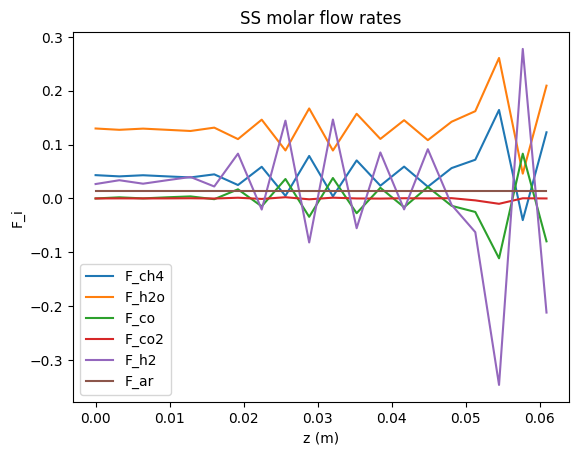

In [13]:
plt.plot(soln.x, soln.y[0], label='F_ch4')
plt.plot(soln.x, soln.y[1], label='F_h2o')
plt.plot(soln.x, soln.y[2], label='F_co')
plt.plot(soln.x, soln.y[3], label='F_co2')
plt.plot(soln.x, soln.y[4], label='F_h2')
plt.plot(soln.x, soln.y[5], label='F_ar')
plt.xlabel('z (m)')
plt.ylabel('F_i')
plt.title('SS molar flow rates')
plt.legend()

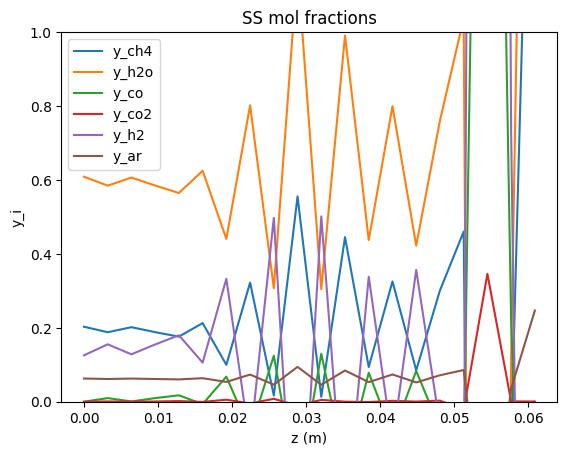

In [14]:
y = soln.y[:6]/np.sum(soln.y[:6], axis = 0)
plt.plot(soln.x, y[0], label='y_ch4')
plt.plot(soln.x, y[1], label='y_h2o')
plt.plot(soln.x, y[2], label='y_co')
plt.plot(soln.x, y[3], label='y_co2')
plt.plot(soln.x, y[4], label='y_h2')
plt.plot(soln.x, y[5], label='y_ar')
plt.ylim(0, 1)
plt.xlabel('z (m)')
plt.ylabel('y_i')
plt.title('SS mol fractions')
plt.legend()

Text(0.5, 1.0, 'Temperature profile')

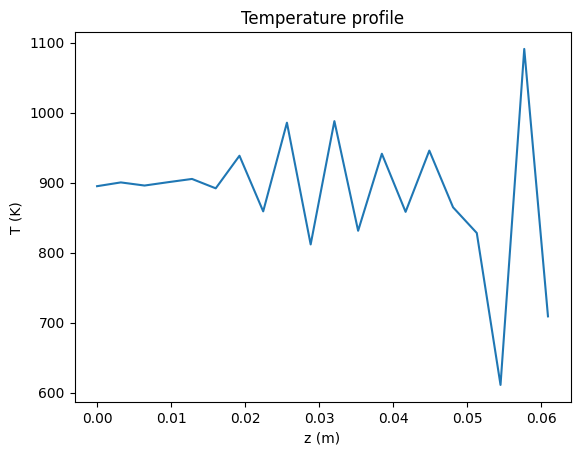

In [15]:
plt.plot(soln.x, soln.y[6])
plt.xlabel('z (m)')
plt.ylabel('T (K)')
plt.title('Temperature profile')

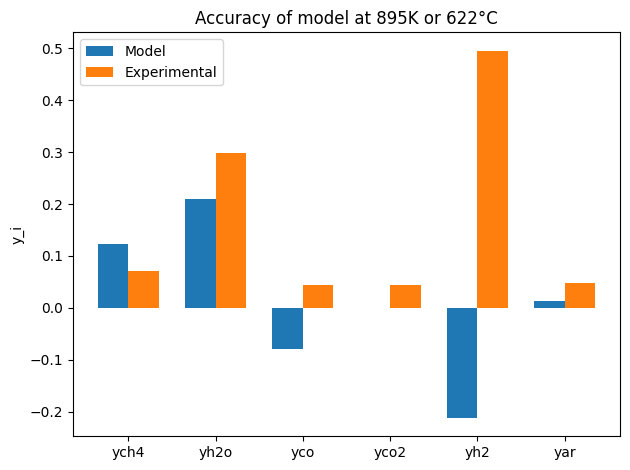

0.0542711070171189


In [16]:
# Assign experimental data based on temperature
if Tin == 622 + 273:
    yexp = [0.071787506, 0.298008466, 0.043658696, 0.043658696, 0.495104008, 0.047782628]
elif Tin == 721 + 273:
    yexp = [0.019206098, 0.189598069, 0.090570208, 0.034350264, 0.619497555, 0.046777807]
elif Tin == 573 + 273:
    yexp = [0.101830373, 0.416886827, 0.02267593, 0.043676434, 0.365008486, 0.04992194]
elif Tin == 522 + 273:
    yexp = [0.135048125, 0.331577273, 0.010516725, 0.034486466, 0.436794105, 0.051577306]
else:
    print('Sorry, we don’t have experimental data for that temperature.')
    yexp = [0, 0, 0, 0, 0, 0]


# Define categories
categories = ['ych4', 'yh2o', 'yco', 'yco2', 'yh2', 'yar']
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Plot
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, soln.y[:6,-1], width, label='Model')
bars2 = ax.bar(x + width/2, yexp, width, label='Experimental')

# Labels and legend
ax.set_ylabel('y_i')
ax.set_title(f'Accuracy of model at {Tin}K or {Tin - 273}°C')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.tight_layout()
plt.show()

print(np.sum(soln.y[:6,-1]))